   Prof    Age  Sigma_Age
0   4.8   9750         40
1   4.9  10175         50
2   5.2  11170        100
3   6.4  20050         80
4   8.4  29980        970
5   8.7  34100        290
6   9.1  40000        600
7  10.2  49800       1500
8  12.8  69500        380


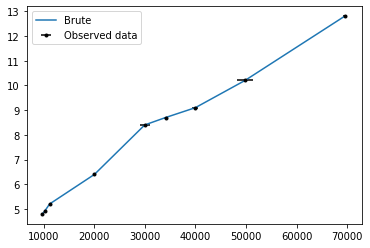

In [170]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
#from mpl_toolkits.mplot3d import Axes3D
#from matplotlib.mlab import griddata
import matplotlib.tri as tri
import pandas as pd 
import numpy as np
import scipy

Data=pd.read_csv('CalibrationAgeC_LGP.txt',sep='\t')
Data.head()
Prof=Data['Prof']
Age=Data['Age']
Sigma_Age=Data['Sigma_Age']
print(Data)
plt.plot(Age,Prof,label="Brute")
plt.errorbar(Age,Prof,xerr=Sigma_Age,fmt='.',color="k",label="Observed data")
plt.legend()

In [171]:
from scipy.optimize import curve_fit 
import uncertainties
def forward_model(x,a,b):
    """forward model for our problem"""
    return a + x*b
def lognormal(x,mu,std):
    var = std**2
    return -0.5*((x-mu)**2/var + np.log(2.0*np.pi*var))
def logprior(theta):
    a ,b = theta
    if -20 < a < 30 \
    and -10 < b < 10:
        return 0.0
    else:
        return -np.inf
def loglike(theta,x,y,yerr):
    model = forward_model(x,*theta)
    ln_likely = np.sum(lognormal(y,model,yerr))
    return ln_likely
def logjoint(theta, x,y, yerr):
    lp = logprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + loglike(theta,x,y,yerr)

In [172]:
theta_start = [0.,1.]
if logprior(theta_start) == 0:
    print("Modèle viable")
import scipy.optimize as op
N=9
ese = 10*np.random.randn(N)

y_observed = Prof + ese

chi2 = lambda *args: -2 * logjoint(*args)
result = op.minimize(chi2, theta_start, args=(Age, y_observed,ese))
print(result)

Modèle viable
      fun: 58.475951472585436
 hess_inv: array([[ 7.07338819e+00, -1.52736072e-04],
       [-1.52736072e-04,  3.53886027e-09]])
      jac: array([-4.76837158e-07, -1.43051147e-06])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 5
     njev: 6
   status: 0
  success: True
        x: array([1.99039872e+00, 1.99978738e-04])


Parametères obtenus:
[1.99039872]
Biais estimés:
1.0001999987346908
Fit RMSE est : 1270.0039152804652


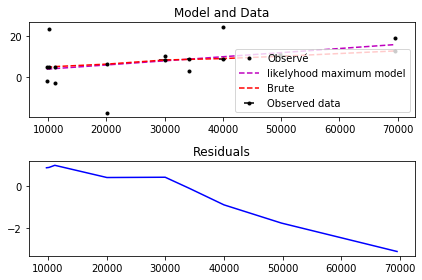

In [173]:
popt_2 = result['x'][:]
print("Parametères obtenus:")
print(result['x'][:-1])

print("Biais estimés:")
print(np.exp(result['x'][-1]))

y_pred_minimize = forward_model(Age,*popt_2) 
popt, pcov = curve_fit(forward_model,Age,y_observed,sigma=ese) 
y_pred_curvefit = forward_model(Age,*popt) 

print("Fit RMSE est : "+str(np.sum((y_pred_minimize-y_observed)**2)))

plt.figure()

plt.subplot(2,1,1)
plt.plot(Age,y_observed,"k.",label="Observé")
plt.plot(Age,y_pred_minimize,"m--",label="likelyhood maximum model")
plt.plot(Age,Prof,"r--",label="Brute")
plt.errorbar(Age,Prof,xerr=Sigma_Age,fmt='.',color="k",label="Observed data")
plt.title("Model and Data")
plt.legend()

plt.subplot(2,1,2)
plt.plot(Age,(Prof-y_pred_curvefit),"b-")
plt.title("Residuals")

plt.tight_layout()

In [174]:
def mcmc(x,y,yerr,theta_start,scales,nb_iter):
    logrecord = np.zeros(nb_iter)
    theta_record = np.zeros((nb_iter,len(theta_start)))
    
    accepted = 0
    
    logrecord[0] = logjoint(theta_start,x,y,yerr)
    theta_record[0,:] = theta_start
    
    i = 1
    while i < nb_iter:
        theta_0 = theta_record[i-1,:] + scales*np.random.randn(2)
        logprob_theta0 = logjoint(theta_0,x,y,yerr)
        alpha = logprob_theta0 - logrecord[i-1]
        
        if np.exp(alpha) > np.random.rand(): 
            logrecord[i] = logprob_theta0
            theta_record[i,:] = theta_0
            accepted = accepted + 1
        else: 
            logrecord[i] = logrecord[i-1]
            theta_record[i,:] = theta_record[i-1,:]
            
        i += 1 
            
    acceptance_rate = accepted/(nb_iter-1)
    
    return theta_record, logrecord, acceptance_rate
def polyfit(x, y, degree):
    results = {}
    coeffs = np.polyfit(x, y, degree)
    results['polynomial'] = coeffs.tolist()
    correlation = np.corrcoef(x, y)[0,1]
    results['correlation'] = correlation
    results['determination'] = correlation**2
    return results
BestValeur = polyfit(Age,Prof,1)
print(BestValeur)

{'polynomial': [0.00013319663543629752, 3.77046596187227], 'correlation': 0.993477016123995, 'determination': 0.9869965815666366}


In [183]:
a=0.00013319663543629752
b=0.0001577046596187227
theta_start = result['x'] 

scales = [1,1e-4]
scales_test = scales*np.random.randn(2)
print("Parameters starting value: "+str(theta_start)) 
print("Perturbations: "+str(scales_test))
nb_iter= 10000
nb_chains = 5

chains_theta = []
chains_logrecord = []
chains_acceptance = []

for i in range(nb_chains):
    theta_mcmc, logrecord_mcmc, acceptance_rate = mcmc(Age,Prof,ese,theta_start,scales,nb_iter)
    chains_theta.append(theta_mcmc)
    chains_logrecord.append(logrecord_mcmc)
    chains_acceptance.append(acceptance_rate)
print(chains_acceptance)
Burnin = 2000

samples_MH=[]
for i in range(nb_chains):
    samples_MH.append(chains_theta[i][Burnin:-1,:])
samples_MH = np.concatenate(samples_MH)

a_mcmc = np.median(samples_MH[:,0])
b_mcmc = np.median(samples_MH[:,1])
nb_drawn_samples = len(samples_MH)
print(samples_MH)

Parameters starting value: [1.99039872e+00 1.99978738e-04]
Perturbations: [ 4.59847117e-01 -3.84797097e-05]
[0.25092509250925094, 0.25092509250925094, 0.24302430243024303, 0.25272527252725274, 0.25942594259425944]
[[ 6.33788255e-01  2.41902352e-04]
 [ 6.33788255e-01  2.41902352e-04]
 [ 6.33788255e-01  2.41902352e-04]
 ...
 [-2.57390324e-02  2.11253099e-04]
 [-2.57390324e-02  2.11253099e-04]
 [-2.57390324e-02  2.11253099e-04]]


0     3.940191
1     4.025182
2     4.224161
3     5.999972
4     7.985761
5     8.809674
6     9.989548
7    11.949340
8    15.888921
Name: Age, dtype: float64


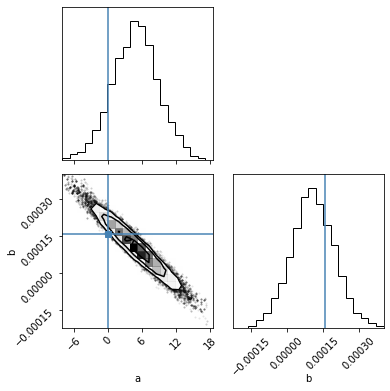

In [184]:
#Représentation
print(y_pred_minimize)
import corner
labels = ['a','b','c','lnf']
fig_mh = corner.corner(samples_MH,labels=labels,truths=[a, b])
plt.tight_layout()

[3.87585372e+00 8.66932464e-05]


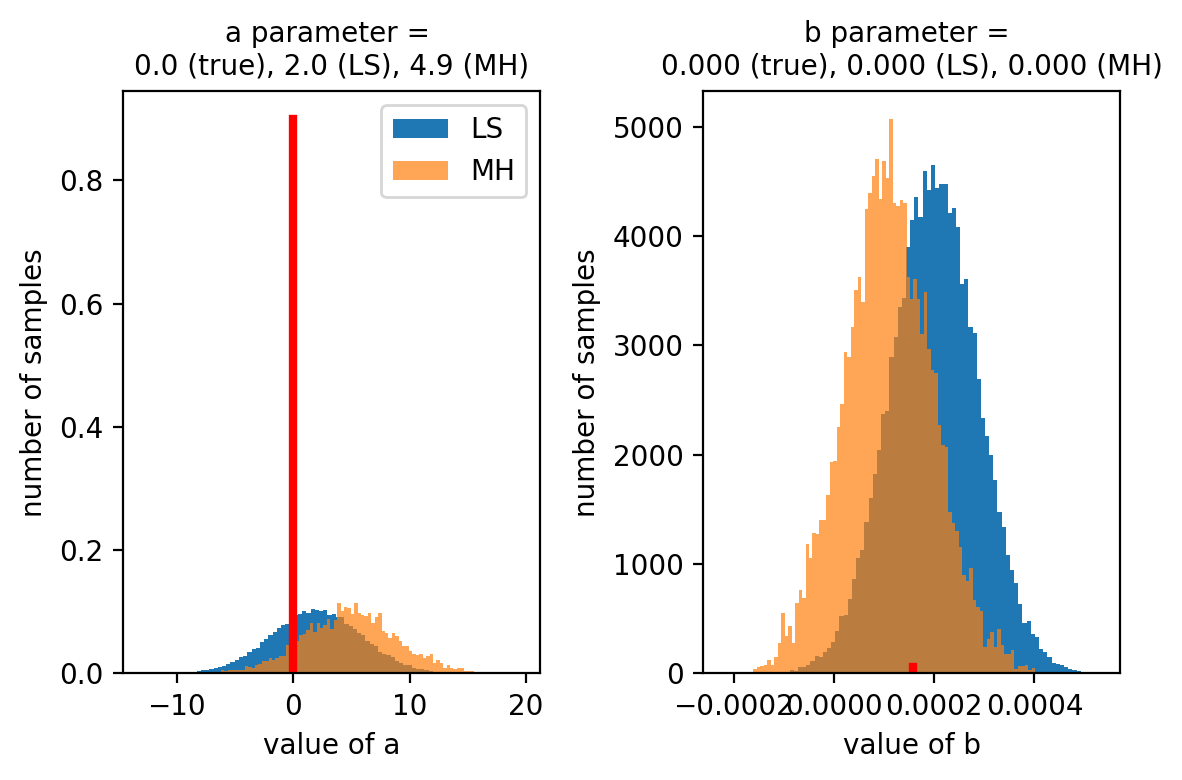

In [185]:
popt, pcov = curve_fit(forward_model,Age,y_observed,sigma=ese) 
perr = np.sqrt(np.diag(pcov)) 
print(perr)

plt.figure(dpi=200)
plt.subplot(1,2,1)
plt.title("a parameter = \n{:.1f} (true), {:.1f} (LS), {:.1f} (MH)".format(a,popt[0],a_mcmc),fontsize=10)
plt.hist(np.random.normal(loc=popt[0],scale=perr[0],size = nb_drawn_samples),
         bins = 90,density=True,label="LS")
plt.hist(samples_MH[:,0],
                 alpha=0.7,bins=90,density=True,label="MH")
plt.plot([a,a],[0,0.9],"r-",linewidth=3)
plt.xlabel("value of a")
plt.ylabel("number of samples")
plt.legend(loc="best")

plt.subplot(1,2,2)
plt.title("b parameter = \n{:.3f} (true), {:.3f} (LS), {:.3f} (MH)".format(b,popt[1],b_mcmc),fontsize=10)
plt.hist(np.random.normal(loc=popt[1],scale=perr[1],size = nb_drawn_samples),
         bins = 90,density=True)
plt.hist(samples_MH[:,1],
                 alpha=0.7,bins=90,density=True)
plt.plot([b,b],[0,60],"r-",linewidth=3)
plt.xlabel("value of b")
plt.ylabel("number of samples")
plt.tight_layout()
plt.show()